In [133]:
# import necessary libraries
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)

import unicodedata, string
from nltk.stem import SnowballStemmer


SEED=42

In [116]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

In [117]:
# cargar los datos
df_original = pd.read_csv('data/tipo1_entrenamiento_estudiantes.csv')

# Entendimiento

In [118]:
df_original.shape

(7875, 2)

In [119]:
df_original.sample(5)

,Review,Class
6667,Contiene dentro la segunda estatua mas alta de america en un lugar cerrado. Lo malo es que estan arreglandolo y no se puede entrar.,5
6548,"El lugar muy bonito, la comida es buena sin ser excelente. Precios bien. La atención del personal bien. El café muy rico. Pedí algunos cambios en el menú que no pudieron hacer. De ahí en fuera todo bien unos huevos motuleños, unos joroches y chilaquiles...Más",3
7466,"Bien situado, aunque para ir centro necesitas taxi, siempre hay en la puerta, Homero es muy recomendable, pregunta por el en la parada es de confianza. El hotel esta bastante deteriorado, lo salva las fantasticas vistas de las plantas altas, mobiliario antiguo, desayuno muy bueno. Necesita reforma urgente . la piscina pasable.Frente al hotel hay un ciber cafe pequeno con mezcla de cocina cubana y europea muy recomendable y nuevas fusiones.",2
5594,"Se encuentra a 3000 m de altura. en nuestro caso ascendimos con el funicular. Hermosa vista de toda la ciudad, aunque en nuestro caso nos acompañó un día de lluvia. El Sanrtuario del "" Señor Caído"" exibe una talla de madera del siglo XVI que le atribuyen poderes curativos. Originariamente fue un convento de Cartujos. Hoy es un lugar de peregrinación de gran valor religioso y además se puede disfrutar de dos restaurantes de muy buen nivel en la ambientación y en las comidas.Icono de Bogotá. Debe visitarse",4
7397,"En definitiva hay que ir, te lo recorres en dos horas y de ahí a comer! Ahí aprendes que lleva Colombia en la sangre y de los esplendores de su nacimiento!",4


In [120]:
df_original.isnull().sum()

Review    0
Class     0
dtype: int64

No hay registros nulos, los datos son completos.

<Axes: xlabel='Class'>

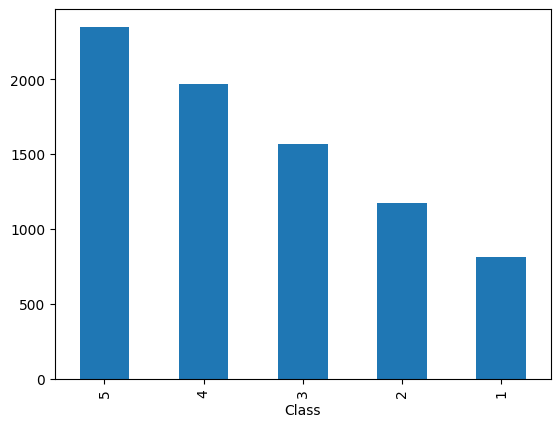

In [121]:
# distribución de variable objetivo
df_original['Class'].value_counts().plot(kind='bar')

Todos los valores de la columna 'Class' son válidos.

In [122]:
df_original.duplicated().sum()

71

Hay 71 registro duplicados, estos se deben eliminar del dataset.

In [123]:
duplicated_rows = df_original[df_original.duplicated()]
duplicated_rows


,Review,Class
518,"La ubicación es muy buena, al igual que la vista, la playa contrario a lo que esperaba resultó que estaba bastante limpia.\nSe percibe el sabor y la frescura en los insumos de los alimentos , lo cual es parte de la experiencia que ofrece...el lugar ya que tienen sus propias granjas productoras. La carta es limitada ( lo cual en mi caso prefiero, ya que se nota el esmero en cada uno de los platos que preparan), los precios están por arriba del promedio de otros restaurantes cercanos pero no llegan a ser exagerados, desconozco si eso se debió a que solo se tenía un salón disponible, ya que en la fecha que lo visité, el resto del restaurante se encontraba en remodelación (es la único razón por lo cual no otorgo la evaluación más alta), mi sugerencia sería que siguieran manteniendo los precios ya que los hace muy competitivos … sin duda regresaría, es un lugar que debes visitar en Veracruz sobre todo si eres fanático del buen comer…Más",4
1112,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
1605,"Cierran a las 3 pm, cobraron $85 adultos y niños (por lo menos los de 2 años) y adulto mayor gratis. A la entrada hay guías. Se juntan grupos de mínimo 10 personas y te cobran $70 por persona o $700 a quien se los pague. Excelente explicación y atención de parte de ellos. Poca claridad de información en redes, y el número telefónico no sirve. Llegamos fácilmente con waze. Lleven buen bloqueador, sombrero y de preferencia tenis.",3
1843,"Acudimos un sábado 2 de julio a las 11:15 de la mañana. Estuvimos esperando más de media hora nosotros dos y otro grupo de cuatro personas fuera, porque la camarera estaba dentro. Nos vio como estábamos esperando y no fue capaz de salir a atendernos...o dar alguna explicación si el bar estaba abierto o cerrado.\n\nNos tuvimos que marcharMás",1
1851,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
...,...,...
7520,"Un lugar muy limpio ordenado hermoso con áreas amplias que vale la pena disfrutar en familia un momento, primera vez que lo visito pero vale la pena acudir.",3
7601,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
7756,Deben de actualizar los horarios en las diferentes páginas ya que como yo o cualquiera de los visitantes que vamos podemos llegar y encontrar cerrado y luego la página para buscar información no funciona.,3
7794,"Wow Había escuchado muchas recomendaciones de este lugar, pero nunca había ido, hace unos fui y me precio muy interesante toda las historias que hay en este museo.",5


# Procesamiento y Preparación

In [124]:
# eliminar las filas duplicadas
df_prep = df_original.drop_duplicates()

In [125]:
df_prep.shape

(7804, 2)

In [35]:
# TODO: balancear las clases (variable objetivo)

## Divisón en entrenamiento y prueba 

In [126]:
X_train, X_test, y_train, y_test = train_test_split(df_prep["Review"], df_prep["Class"], test_size = 0.2, stratify = df_prep["Class"], random_state = SEED)

In [127]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6243,), (1561,), (6243,), (1561,))

## Tokenización / Vectorización

"Feature engineering"

* Bag of Words / Count Tokenizer
* Tf-IDF

In [128]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marianaforero/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marianaforero/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [129]:
stop_words = set(stopwords.words('spanish'))

In [130]:
def tokenize_text(text):
    # convertir a minúsculas
    text = text.lower()
    
    # eliminar caracteres numericos
    text = re.sub(r'\d+', '', text) 

    # eliminar puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # eliminar caracters especiales
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons TODO: not all emojis included here
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               "]+", flags=re.UNICODE)
    
    text = emoji_pattern.sub(r'', text)

    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')  
    # text = remove_non_ascii(text)
     
    tokens = word_tokenize(text)

    # eliminar los stems de las palabras
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(t) for t in tokens]
    return tokens

In [131]:
bow_vectorizer = CountVectorizer(stop_words=list(stop_words), lowercase=True, tokenizer=tokenize_text)
tfidf_vectorizer = TfidfVectorizer( stop_words=list(stop_words), lowercase=True, tokenizer=tokenize_text)

In [134]:
X_train_bow = bow_vectorizer.fit_transform(X_train)

/Users/marianaforero/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [135]:
len(bow_vectorizer.vocabulary_)

13491

In [136]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

/Users/marianaforero/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estareis', 'estari', 'estariais', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'estuvier', 'estuvies', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habeis', 'habi', 'habiais', 'habr', 'habreis', 'habri', 'habriais', 'hast', 'hayais', 'hem', 'hub', 'hubier', 'hubies', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'sereis', 'seri', 'seriais', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambi', 'tant', 'ten', 'tendr', 'tendreis', 'tendri', 'tendriais', 'teneis', 'teng', 'tengais', 'teni', 'teniais', 'tien', 'tod', 'tuv', 'tuvier', 'tuvies', 'tuy', 'vosotr', 'vuestr'] n

In [104]:
len(tfidf_vectorizer.vocabulary_)

24863

In [137]:
df_bow_sklearn = pd.DataFrame(X_train_bow.toarray(),columns=bow_vectorizer.get_feature_names_out())
df_bow_sklearn

,...,......,8,aa,aaaaa,aaaah,aasequ,ab,abad,abaj,...,zonatambi,zoo,zoofari,zoolog,zorr,zotan,zuegly,zul,zum,zumb
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6240,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Entrenamiento y evaluación de modelos

## Regresion Logistica

Desarrollado por: Mariana Forero

In [138]:
# Train the logistic regression model
model = LogisticRegression(multi_class='multinomial', max_iter=1000)  # Increase max_iter for convergence
model.fit(X_train_bow, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [139]:
x_test_vec=bow_vectorizer.transform(X_test)

In [140]:
y_pred = model.predict(x_test_vec)

In [141]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4695707879564382


In [142]:
# Other metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.39      0.43       158
           2       0.35      0.33      0.34       232
           3       0.36      0.37      0.36       310
           4       0.42      0.42      0.42       393
           5       0.63      0.67      0.65       468

    accuracy                           0.47      1561
   macro avg       0.45      0.44      0.44      1561
weighted avg       0.47      0.47      0.47      1561



In [143]:
print("F1:", f1_score(y_test, y_pred, average='micro'))

F1: 0.4695707879564382


In [144]:
coefficients = model.coef_


In [146]:
# Print coefficients
print("Coefficients:")
for i, feature_name in enumerate(bow_vectorizer.get_feature_names_out()):
    print(f"{feature_name}: {coefficients[0][i]}")

Coefficients:
...: 0.4114287549561459
......: -0.031666405740650175
8: -0.0018375185378430735
aa: -0.1085909907077137
aaaaa: -0.0037765739984685445
aaaah: -0.0001276914780219683
aasequ: -0.008275677115363384
ab: -1.6330891472124857e-05
abad: -6.2955160076366785e-06
abaj: 0.390553493866585
abajol: -6.133902311390759e-06
abajom: -0.020321246240255417
abalanz: -5.235763431323089e-06
aban: 0.10963296391736478
abandon: 0.5225791255199728
abarat: -3.226147664749167e-06
abarc: -5.765117775059246e-06
abarrot: -0.026510606380893267
abas: -0.011691059265981562
abast: -0.22565825803581052
abastec: -0.02211716515435283
abeit: -0.03515315315306899
abej: -0.0668593016140564
abel: 0.04270600503684218
abertur: -0.13794847741826205
abhorant: 0.0933037088176634
abient: -0.0032174667319652852
abiert: 0.6285140627000393
abiertal: -0.005480206733227128
abiertam: -0.004372184326903435
abiertohay: -0.0005580250012639696
abigail: -0.0007223532889440532
abism: -0.004513808071557916
abismal: -0.0006249616133400

### Conclusiones

## [nombre algoritmo]

Desarrollado por:

[descripción]

### Conclusiones

## [nombre algoritmo]

Desarrollado por:

[descripción]

### Conclusiones

## Selección de final